# Práctica 1 Integración de diversas fuentes de datos con Talend Data Integration o Talend Data Fabric

In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
import json
import re
import unicodedata
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Para visualización
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')

print("Librerías importadas correctamente")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

Librerías importadas correctamente
Pandas version: 2.2.2
NumPy version: 2.0.2


In [2]:
# Funciones de normalización de datos
def normalize_name(name):
    """Normaliza nombres: quita acentos, convierte a mayúsculas, limpia espacios"""
    if pd.isna(name) or name is None:
        return ''

    # Convertir a string
    name = str(name).strip()

    # Quitar acentos
    name = unicodedata.normalize('NFD', name)
    name = ''.join(char for char in name if unicodedata.category(char) != 'Mn')

    # Convertir a mayúsculas y limpiar espacios múltiples
    name = re.sub(r'\s+', ' ', name.upper().strip())

    return name

def normalize_address(address):
    """Normaliza direcciones: quita acentos, convierte a mayúsculas"""
    if pd.isna(address) or address is None:
        return ''

    # Convertir a string
    address = str(address).strip()

    # Quitar acentos
    address = unicodedata.normalize('NFD', address)
    address = ''.join(char for char in address if unicodedata.category(char) != 'Mn')

    # Convertir a mayúsculas y limpiar espacios múltiples
    address = re.sub(r'\s+', ' ', address.upper().strip())

    return address

def normalize_date(date_str):
    """Normaliza fechas a formato YYYY-MM-DD"""
    if pd.isna(date_str) or date_str is None:
        return None

    date_str = str(date_str).strip()

    # Intentar diferentes formatos
    formats = ['%d/%m/%Y', '%Y-%m-%d', '%m/%d/%Y', '%Y/%m/%d', '%d-%m-%Y']

    for fmt in formats:
        try:
            return datetime.strptime(date_str, fmt).strftime('%Y-%m-%d')
        except ValueError:
            continue

    return None

print("Funciones de normalización definidas")

Funciones de normalización definidas


In [3]:
# 1.1 Cargar datos desde CSV - Médica Sur
try:
    csv_path = r"/content/PacientesMedicaSurCSV.csv"
    df_medica_sur = pd.read_csv(csv_path)

    print("=== FUENTE CSV - MÉDICA SUR ===")
    print(f"Archivo: {csv_path}")
    print(f"Filas: {len(df_medica_sur)}")
    print(f"Columnas: {list(df_medica_sur.columns)}")
    print("\nPrimeros registros:")
    print(df_medica_sur.head())
    print(f"\nTipos de datos:")
    print(df_medica_sur.dtypes)

except FileNotFoundError:
    print(f"Error: No se encontró el archivo {csv_path}")
    df_medica_sur = pd.DataFrame()
except Exception as e:
    print(f"Error al cargar CSV: {e}")
    df_medica_sur = pd.DataFrame()

=== FUENTE CSV - MÉDICA SUR ===
Archivo: /content/PacientesMedicaSurCSV.csv
Filas: 114
Columnas: ['NoPaciente', 'fecha_nac', 'NombreCompleto', 'ubicacion']

Primeros registros:
      NoPaciente   fecha_nac    NombreCompleto                 ubicacion
0  16000327 1780  01/03/1991    Eduard Pizarro  8369 Dignissim Carretera
1  16010302 5417  25/08/1986      Eduar Zúñiga     933-1665 Non, Avenida
2  16020326 9147  24/12/2000    Josue Saavedra  Apdo.:384-643 Libero Av.
3  16040103 3881  16/05/2006  Roxana Hernández     Apdo.:455-7520 Etiam 
4  16040309 8312  25/10/1998  Yordano Sandoval        7542 Sit Carretera

Tipos de datos:
NoPaciente        object
fecha_nac         object
NombreCompleto    object
ubicacion         object
dtype: object


In [4]:
# 1.2 Cargar datos desde JSON - Hospital ABC
try:
    json_path = r"/content/PacientesHospitalABC.json"
    with open(json_path, 'r', encoding='utf-8') as f:
        json_data = json.load(f)

    # El JSON es directamente una lista, no tiene clave 'pacientes'
    df_abc = pd.DataFrame(json_data)

    print("=== FUENTE JSON - HOSPITAL ABC ===")
    print(f"Archivo: {json_path}")
    print(f"Filas: {len(df_abc)}")
    print(f"Columnas: {list(df_abc.columns)}")
    print("\nPrimeros registros:")
    print(df_abc.head())
    print(f"\nTipos de datos:")
    print(df_abc.dtypes)

except FileNotFoundError:
    print(f"Error: No se encontró el archivo {json_path}")
    df_abc = pd.DataFrame()
except json.JSONDecodeError as e:
    print(f"Error al decodificar JSON: {e}")
    df_abc = pd.DataFrame()
except Exception as e:
    print(f"Error al cargar JSON: {e}")
    df_abc = pd.DataFrame()

=== FUENTE JSON - HOSPITAL ABC ===
Archivo: /content/PacientesHospitalABC.json
Filas: 100
Columnas: ['NOMBRE', 'APELLIDO', 'NSS', 'Direccion']

Primeros registros:
        NOMBRE  APELLIDO          NSS                     Direccion
0  Christopher  Cárdenas  61298736999  Apdo.:881-3974 Velit Avenida
1       Andres   Navarro  87305668399  Apdo.:214-9519 Fusce Avenida
2         Manu  Gallardo  85496864999       Apdo.:464-3974 Enim. C/
3        Lucca     Tapia  67331835899           865-4550 Nunc Calle
4     Priscila   Jiménez  91996735699            221-6477 Cum Calle

Tipos de datos:
NOMBRE       object
APELLIDO     object
NSS          object
Direccion    object
dtype: object


In [5]:
# 1.3 Cargar datos desde SQL - Hospital Siglo XXI
def parse_sql_file(file_path):
    """Parsea un archivo SQL y extrae los datos"""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            sql_content = f.read()

        print("=== CONTENIDO DEL ARCHIVO SQL ===")
        print(sql_content[:500] + "...")

        # Buscar CREATE TABLE para obtener estructura
        create_pattern = r'CREATE TABLE\s+`?(\w+)`?\s*\((.*?)\);'
        create_match = re.search(create_pattern, sql_content, re.IGNORECASE | re.DOTALL)

        columns = []
        if create_match:
            table_name = create_match.group(1)
            columns_def = create_match.group(2)

            # Extraer nombres de columnas
            column_lines = [line.strip() for line in columns_def.split(',')]
            for line in column_lines:
                if line and not line.upper().startswith('PRIMARY') and not line.upper().startswith('KEY'):
                    col_match = re.match(r'`?(\w+)`?', line.strip())
                    if col_match:
                        columns.append(col_match.group(1))

            print(f"Tabla encontrada: {table_name}")
            print(f"Columnas detectadas: {columns}")

        # Buscar INSERT statements
        insert_pattern = r'INSERT INTO.*?VALUES\s*(.+?);'
        insert_matches = re.findall(insert_pattern, sql_content, re.IGNORECASE | re.DOTALL)

        all_data = []
        for insert_values in insert_matches:
            # Buscar tuplas de valores
            value_tuples = re.findall(r'\(([^)]+)\)', insert_values)
            for value_tuple in value_tuples:
                values = []
                parts = re.split(r',(?=(?:[^\']*\'[^\']*\')*[^\']*$)', value_tuple)
                for part in parts:
                    part = part.strip()
                    if part.startswith("'") and part.endswith("'"):
                        part = part[1:-1]
                    elif part.upper() == 'NULL':
                        part = None
                    values.append(part)
                all_data.append(values)

        # Si no hay datos reales, crear datos simulados
        if not all_data and columns:
            print("No se encontraron INSERT statements. Generando datos simulados...")
            all_data = [
                ['Juan Pérez García', 'Av. Insurgentes 123, CDMX'],
                ['María López Hernández', 'Calle Reforma 456, CDMX'],
                ['Carlos Martínez Silva', 'Av. Universidad 789, CDMX'],
                ['Ana González Ruiz', 'Calle Madero 101, CDMX'],
                ['Luis Rodríguez Torres', 'Av. Juárez 202, CDMX']
            ]

        # Crear DataFrame
        if all_data:
            # Asegurar que tenemos las columnas correctas
            if not columns:
                columns = ['NOMBRE', 'Direccion']

            # Ajustar datos a columnas
            max_cols = min(len(columns), max(len(row) for row in all_data) if all_data else 0)
            df = pd.DataFrame([row[:max_cols] for row in all_data], columns=columns[:max_cols])
            return df
        else:
            return pd.DataFrame()

    except Exception as e:
        print(f"Error al parsear SQL: {e}")
        return pd.DataFrame()

try:
    sql_path = r"/content/PacientesSiglo21-mysql.sql"
    df_siglo21 = parse_sql_file(sql_path)

    print("\n=== FUENTE SQL - HOSPITAL SIGLO XXI ===")
    print(f"Archivo: {sql_path}")
    print(f"Filas: {len(df_siglo21)}")
    print(f"Columnas: {list(df_siglo21.columns)}")
    print("\nPrimeros registros:")
    print(df_siglo21.head())

except Exception as e:
    print(f"Error general al cargar SQL: {e}")
    df_siglo21 = pd.DataFrame()

=== CONTENIDO DEL ARCHIVO SQL ===
DROP TABLE `Pacientes`;

CREATE TABLE `Pacientes` (
  `NOMBRE` varchar(255) default NULL,
  `APELLIDO` varchar(255) default NULL,
  `NSS` varchar(11) default NULL,
  `Direccion` varchar(255) default NULL
);

INSERT INTO `Pacientes` (`NOMBRE`,`APELLIDO`,`NSS`,`Direccion`) VALUES ("Emilie","Poblete","69699138699","Apdo.:148-1751 Molestie. Ctra."),("Alexis","Soto","25496940399","1977 Tortor. Avenida"),("Fredy","Garrido","95785682099","638-2965 Enim. Av."),("Violeta","Poblete","33492773299","307-533...
Tabla encontrada: Pacientes
Columnas detectadas: ['NOMBRE', 'APELLIDO', 'NSS', 'Direccion']

=== FUENTE SQL - HOSPITAL SIGLO XXI ===
Archivo: /content/PacientesSiglo21-mysql.sql
Filas: 120
Columnas: ['NOMBRE', 'APELLIDO', 'NSS', 'Direccion']

Primeros registros:
      NOMBRE   APELLIDO            NSS                         Direccion
0   "Emilie"  "Poblete"  "69699138699"  "Apdo.:148-1751 Molestie. Ctra."
1   "Alexis"     "Soto"  "25496940399"            "19

In [6]:
# 1.4 Cargar datos desde Excel - Grupo Ángeles
try:
    excel_path = r"/content/PacientesGpoAngeles-excel.xlsx"
    df_angeles = pd.read_excel(excel_path)

    print("=== FUENTE EXCEL - GRUPO ÁNGELES ===")
    print(f"Archivo: {excel_path}")
    print(f"Filas: {len(df_angeles)}")
    print(f"Columnas: {list(df_angeles.columns)}")
    print("\nPrimeros registros:")
    print(df_angeles.head())
    print(f"\nTipos de datos:")
    print(df_angeles.dtypes)

except FileNotFoundError:
    print(f"Error: No se encontró el archivo {excel_path}")
    df_angeles = pd.DataFrame()
except Exception as e:
    print(f"Error al cargar Excel: {e}")
    # Crear datos simulados para Excel
    df_angeles = pd.DataFrame({
        'ID': range(1, 6),
        'NombrePaciente': ['Roberto Silva Moreno', 'Patricia Jiménez Vega',
                          'Fernando Castro López', 'Sandra Morales Ruiz', 'Diego Herrera Peña'],
        'Domicilio': ['Col. Roma Norte, CDMX', 'Col. Condesa, CDMX',
                     'Col. Polanco, CDMX', 'Col. Coyoacán, CDMX', 'Col. Del Valle, CDMX']
    })
    print("Usando datos simulados para Grupo Ángeles")
    print(f"Filas: {len(df_angeles)}")
    print(f"Columnas: {list(df_angeles.columns)}")
    print(df_angeles.head())
    print(df_angeles.dtypes)

=== FUENTE EXCEL - GRUPO ÁNGELES ===
Archivo: /content/PacientesGpoAngeles-excel.xlsx
Filas: 113
Columnas: ['NOMBRE', 'APELLIDO', 'DIRECCION', 'NSS']

Primeros registros:
  NOMBRE APELLIDO                   DIRECCION       NSS
0   Aiko   Guerra       3475 Aliquet, Avenida  11992415
1    Ali   Dawson  Apdo.:586-973 Et Carretera  50087709
2    Ali   Dawson  Apdo.:586-973 Et Carretera  50087709
3  Amela  Aguirre             491-8014 At, C.  38345197
4    Amy  Anthony    974-7426 Malesuada Calle  49374365

Tipos de datos:
NOMBRE       object
APELLIDO     object
DIRECCION    object
NSS           int64
dtype: object


In [7]:
print(df_angeles.head())

  NOMBRE APELLIDO                   DIRECCION       NSS
0   Aiko   Guerra       3475 Aliquet, Avenida  11992415
1    Ali   Dawson  Apdo.:586-973 Et Carretera  50087709
2    Ali   Dawson  Apdo.:586-973 Et Carretera  50087709
3  Amela  Aguirre             491-8014 At, C.  38345197
4    Amy  Anthony    974-7426 Malesuada Calle  49374365


In [8]:
print(df_siglo21.head())

      NOMBRE   APELLIDO            NSS                         Direccion
0   "Emilie"  "Poblete"  "69699138699"  "Apdo.:148-1751 Molestie. Ctra."
1   "Alexis"     "Soto"  "25496940399"            "1977 Tortor. Avenida"
2    "Fredy"  "Garrido"  "95785682099"              "638-2965 Enim. Av."
3  "Violeta"  "Poblete"  "33492773299"                  "307-5338 Montes
4  "Yanella"     "Vega"  "30595352499"       "Apdo.:566-6914 In Avenida"


In [9]:
print(df_abc.head())

        NOMBRE  APELLIDO          NSS                     Direccion
0  Christopher  Cárdenas  61298736999  Apdo.:881-3974 Velit Avenida
1       Andres   Navarro  87305668399  Apdo.:214-9519 Fusce Avenida
2         Manu  Gallardo  85496864999       Apdo.:464-3974 Enim. C/
3        Lucca     Tapia  67331835899           865-4550 Nunc Calle
4     Priscila   Jiménez  91996735699            221-6477 Cum Calle


In [10]:
print(df_medica_sur.head())

      NoPaciente   fecha_nac    NombreCompleto                 ubicacion
0  16000327 1780  01/03/1991    Eduard Pizarro  8369 Dignissim Carretera
1  16010302 5417  25/08/1986      Eduar Zúñiga     933-1665 Non, Avenida
2  16020326 9147  24/12/2000    Josue Saavedra  Apdo.:384-643 Libero Av.
3  16040103 3881  16/05/2006  Roxana Hernández     Apdo.:455-7520 Etiam 
4  16040309 8312  25/10/1998  Yordano Sandoval        7542 Sit Carretera


## Actividad 1: Mapeo de Esquemas y Normalización

Ahora vamos a mapear los campos de cada fuente a un esquema unificado basado en las columnas reales encontradas.

| Siglo 21      | ABC          | Medica Sur                          | Gpo Angeles          | PacientesFederado         |
|---------------|--------------|-------------------------------------|----------------------|---------------------------|
| NSS str       | NSS obj      | NoPaciente obj                      | NSS int64            | pac_clave int(8)          |
| NOMBRE str    | NOMBRE obj   | NombreCompleto obj                  | NOMBRE obj           | nombrePac varchar(30)     |
| APELLIDO str  | APELLIDO obj | split(NombreCompleto,' ')[1]        | APELLIDO obj         | apePatPac varchar(30)     |
|               |              |                                     |                      | apeMatPac varchar(30)     |
| Direccion str | Direccion obj| ubicacion obj                       | DIRECCION obj        | direccion varchar(30)     |
|               |              |                                     |                      | hospOrigen varchar(15)    |


In [11]:
def map_medica_sur(df):
    if df.empty:
        return pd.DataFrame()

    mapped = pd.DataFrame()
    mapped['pac_clave'] = df['NoPaciente'].astype(str)
    mapped['nombrePac'] = df['NombreCompleto'].str.split(' ').str[0].apply(normalize_name)
    mapped['apePatPac'] = df['NombreCompleto'].str.split(' ').str[1].apply(normalize_name)
    mapped['apeMatPac'] = df['NombreCompleto'].str.split(' ').str[2:].str.join(' ').apply(normalize_name)
    mapped['direccion'] = df['ubicacion'].apply(normalize_address)
    mapped['hospOrigen'] = 'Médica Sur'

    return mapped

def map_abc(df):
    if df.empty:
        return pd.DataFrame()

    mapped = pd.DataFrame()
    mapped['pac_clave'] = df['NSS'].astype(str)
    mapped['nombrePac'] = df['NOMBRE'].apply(normalize_name)
    mapped['apePatPac'] = df['APELLIDO'].apply(normalize_name)
    mapped['apeMatPac'] = ''
    mapped['direccion'] = df['Direccion'].apply(normalize_address)
    mapped['hospOrigen'] = 'Hospital ABC'

    return mapped

def map_siglo21(df):
    if df.empty:
        return pd.DataFrame()

    mapped = pd.DataFrame()
    mapped['pac_clave'] = df['NSS'].astype(str)
    mapped['nombrePac'] = df['NOMBRE'].apply(normalize_name)
    mapped['apePatPac'] = df['APELLIDO'].apply(normalize_name)
    mapped['apeMatPac'] = ''
    mapped['direccion'] = df['Direccion'].apply(normalize_address)
    mapped['hospOrigen'] = 'Hospital Siglo XXI'

    return mapped

def map_angeles(df):
    if df.empty:
        return pd.DataFrame()

    mapped = pd.DataFrame()
    mapped['pac_clave'] = df['NSS'].astype(str)
    mapped['nombrePac'] = df['NOMBRE'].apply(normalize_name)
    mapped['apePatPac'] = df['APELLIDO'].apply(normalize_name)
    mapped['apeMatPac'] = ''
    mapped['direccion'] = df['DIRECCION'].apply(normalize_address)
    mapped['hospOrigen'] = 'Grupo Ángeles'

    return mapped

In [12]:
# Aplicar el mapeo a todas las fuentes
print("=== APLICANDO MAPEO A TODAS LAS FUENTES ===")

# Mapear cada fuente
df_medica_sur_mapped = map_medica_sur(df_medica_sur)
print(f"Médica Sur mapeado: {len(df_medica_sur_mapped)} registros")

df_abc_mapped = map_abc(df_abc)
print(f"Hospital ABC mapeado: {len(df_abc_mapped)} registros")

df_siglo21_mapped = map_siglo21(df_siglo21)
print(f"Hospital Siglo XXI mapeado: {len(df_siglo21_mapped)} registros")

df_angeles_mapped = map_angeles(df_angeles)
print(f"Grupo Ángeles mapeado: {len(df_angeles_mapped)} registros")

# Mostrar resultados de cada mapeo
print(f"\n=== RESULTADOS DEL MAPEO ===")

if not df_medica_sur_mapped.empty:
    print(f"\n--- MÉDICA SUR MAPEADO ---")
    print(df_medica_sur_mapped.head())

if not df_abc_mapped.empty:
    print(f"\n--- HOSPITAL ABC MAPEADO ---")
    print(df_abc_mapped.head())

if not df_siglo21_mapped.empty:
    print(f"\n--- HOSPITAL SIGLO XXI MAPEADO ---")
    print(df_siglo21_mapped.head())

if not df_angeles_mapped.empty:
    print(f"\n--- GRUPO ÁNGELES MAPEADO ---")
    print(df_angeles_mapped.head())

=== APLICANDO MAPEO A TODAS LAS FUENTES ===
Médica Sur mapeado: 114 registros
Hospital ABC mapeado: 100 registros
Hospital Siglo XXI mapeado: 120 registros
Grupo Ángeles mapeado: 113 registros

=== RESULTADOS DEL MAPEO ===

--- MÉDICA SUR MAPEADO ---
       pac_clave nombrePac  apePatPac apeMatPac                 direccion  \
0  16000327 1780    EDUARD    PIZARRO            8369 DIGNISSIM CARRETERA   
1  16010302 5417     EDUAR     ZUNIGA               933-1665 NON, AVENIDA   
2  16020326 9147     JOSUE   SAAVEDRA            APDO.:384-643 LIBERO AV.   
3  16040103 3881    ROXANA  HERNANDEZ                APDO.:455-7520 ETIAM   
4  16040309 8312   YORDANO   SANDOVAL                  7542 SIT CARRETERA   

   hospOrigen  
0  Médica Sur  
1  Médica Sur  
2  Médica Sur  
3  Médica Sur  
4  Médica Sur  

--- HOSPITAL ABC MAPEADO ---
     pac_clave    nombrePac apePatPac apeMatPac                     direccion  \
0  61298736999  CHRISTOPHER  CARDENAS            APDO.:881-3974 VELIT AVENIDA  

## Actividad 2,3,4,5: Consolidación de Datos en DataFrame Unificado

Ahora vamos a consolidar todos los DataFrames mapeados en un solo DataFrame maestro.

In [13]:
# Consolidar todos los DataFrames mapeados
def consolidate_dataframes(dfs_list):
    """Consolida lista de DataFrames en uno solo"""

    # Filtrar DataFrames no vacíos
    valid_dfs = [df for df in dfs_list if not df.empty]

    if not valid_dfs:
        print(" No hay DataFrames válidos para consolidar")
        return pd.DataFrame()

    # Concatenar todos los DataFrames
    consolidated = pd.concat(valid_dfs, ignore_index=True)

    return consolidated

# Lista de DataFrames mapeados
mapped_dfs = [
    df_medica_sur_mapped,
    df_abc_mapped,
    df_siglo21_mapped,
    df_angeles_mapped
]

# Consolidar
df_consolidated = consolidate_dataframes(mapped_dfs)

df_consolidated_copy = df_consolidated.copy()

print("=== DATAFRAME CONSOLIDADO ===")
print(f"Total de registros: {len(df_consolidated)}")
print(f"Total de columnas: {len(df_consolidated.columns)}")
print(f"Columnas: {list(df_consolidated.columns)}")

if not df_consolidated.empty:
    print(f"\n=== RESUMEN POR FUENTE ===")
    print(df_consolidated['hospOrigen'].value_counts())

    print(f"\n=== PRIMEROS 10 REGISTROS CONSOLIDADOS ===")
    print(df_consolidated.head(10))

    print(f"\n=== INFORMACIÓN GENERAL ===")
    print(df_consolidated.info())
else:
    print("  El DataFrame consolidado está vacío")

=== DATAFRAME CONSOLIDADO ===
Total de registros: 447
Total de columnas: 6
Columnas: ['pac_clave', 'nombrePac', 'apePatPac', 'apeMatPac', 'direccion', 'hospOrigen']

=== RESUMEN POR FUENTE ===
hospOrigen
Hospital Siglo XXI    120
Médica Sur            114
Grupo Ángeles         113
Hospital ABC          100
Name: count, dtype: int64

=== PRIMEROS 10 REGISTROS CONSOLIDADOS ===
       pac_clave   nombrePac  apePatPac apeMatPac  \
0  16000327 1780      EDUARD    PIZARRO             
1  16010302 5417       EDUAR     ZUNIGA             
2  16020326 9147       JOSUE   SAAVEDRA             
3  16040103 3881      ROXANA  HERNANDEZ             
4  16040309 8312     YORDANO   SANDOVAL             
5  16040827 1112  FRANCHESKA   MARTINEZ             
6  16050310 2196      WILSON  SEPULVEDA             
7  16050310 3191      WILSON  SEPULVEDA             
8  16060630 2586       DUSAN   GONZALEZ             
9  16060728 5434     JHOSTIN    SANCHEZ             

                       direccion  hosp

## Actividad 2,3,4,5: Eliminacion de duplicados


In [14]:
# Análisis de calidad de datos
if not df_consolidated.empty:
    print("=== ANÁLISIS DE CALIDAD DE DATOS ===\n")

    # 1. Valores nulos por columna (mejorado para detectar diferentes tipos de "vacíos")
    print("1. COMPLETITUD DE DATOS:")
    null_counts = df_consolidated.isnull().sum()
    total_records = len(df_consolidated)

    # Función para detectar valores "vacíos" más completa
    def is_empty_value(value):
        if pd.isna(value):
            return True
        if isinstance(value, str):
            return value.strip() == '' or value.strip().lower() in ['nan', 'none', 'null', 'n/a', 'na']
        return False

    # Calcular valores vacíos para cada columna
    empty_counts = {}
    for col in df_consolidated.columns:
        empty_mask = df_consolidated[col].apply(is_empty_value)
        empty_counts[col] = empty_mask.sum()

    # Crear el DataFrame de calidad correctamente
    quality_data = []
    for col in df_consolidated.columns:
        complete_count = total_records - empty_counts[col]
        empty_count = empty_counts[col]
        completeness_pct = (complete_count / total_records * 100)

        quality_data.append({
            'Campo': col,
            'Valores_Completos': complete_count,
            'Valores_Vacios': empty_count,
            'Porcentaje_Completitud': round(completeness_pct, 2)
        })

    quality_summary = pd.DataFrame(quality_data)
    print(quality_summary)

    # 2. Estadísticas básicas ANTES de deduplicación
    print(f"\n2. ESTADÍSTICAS BÁSICAS (ANTES DE DEDUPLICACIÓN):")
    print(f"Total registros: {len(df_consolidated)}")
    print(f"Registros únicos por ID: {df_consolidated['pac_clave'].nunique()}")
    print(f"IDs duplicados: {df_consolidated['pac_clave'].duplicated().sum()}")

    # 3. Deduplicación basada en ID de paciente y otros campos clave
    print(f"\n3. DEDUPLICACIÓN:")
    initial_count = len(df_consolidated)

    # Eliminar duplicados basándose en pac_clave (ID único) y otros campos clave
    # Usar una combinación de campos para identificar duplicados reales
    df_consolidated = df_consolidated.drop_duplicates(
        subset=['pac_clave', 'nombrePac', 'apePatPac', 'apeMatPac'],
        keep='first'
    )

    final_count = len(df_consolidated)
    duplicates_removed = initial_count - final_count

    print(f"Registros antes de deduplicación: {initial_count}")
    print(f"Registros después de deduplicación: {final_count}")
    print(f"Duplicados eliminados: {duplicates_removed}")

    # 4. Distribución por fuente
    print(f"\n4. DISTRIBUCIÓN POR FUENTE:")
    source_dist = df_consolidated['hospOrigen'].value_counts()
    print(source_dist)

    # 5. Análisis de campos críticos (mejorado)
    print(f"\n5. ANÁLISIS DE CAMPOS CRÍTICOS:")
    critical_fields = ['nombrePac', 'apePatPac', 'apeMatPac', 'direccion']
    for field in critical_fields:
        non_empty = df_consolidated[field].apply(lambda x: not is_empty_value(x))
        completeness = (non_empty.sum() / len(df_consolidated)) * 100
        print(f"  {field}: {completeness:.1f}% con datos válidos")

    # 6. Valores únicos importantes
    print(f"\n6. VALORES ÚNICOS:")
    print(f"  Nombres únicos: {df_consolidated['nombrePac'].nunique()}")
    print(f"  Apellidos paternos únicos: {df_consolidated['apePatPac'].nunique()}")
    print(f"  Apellidos maternos únicos: {df_consolidated['apeMatPac'].nunique()}")
    print(f"  Direcciones únicas: {df_consolidated['direccion'].nunique()}")
    print(f"  Fuentes: {df_consolidated['hospOrigen'].nunique()}")

    # 7. Análisis adicional de valores problemáticos
    print(f"\n7. ANÁLISIS DETALLADO DE VALORES VACÍOS:")
    for col in df_consolidated.columns:
        empty_mask = df_consolidated[col].apply(is_empty_value)
        if empty_mask.any():
            print(f"  {col}: {empty_mask.sum()} valores vacíos")

else:
    print("No hay datos para analizar")

=== ANÁLISIS DE CALIDAD DE DATOS ===

1. COMPLETITUD DE DATOS:
        Campo  Valores_Completos  Valores_Vacios  Porcentaje_Completitud
0   pac_clave                447               0                  100.00
1   nombrePac                447               0                  100.00
2   apePatPac                447               0                  100.00
3   apeMatPac                  1             446                    0.22
4   direccion                447               0                  100.00
5  hospOrigen                447               0                  100.00

2. ESTADÍSTICAS BÁSICAS (ANTES DE DEDUPLICACIÓN):
Total registros: 447
Registros únicos por ID: 418
IDs duplicados: 29

3. DEDUPLICACIÓN:
Registros antes de deduplicación: 447
Registros después de deduplicación: 418
Duplicados eliminados: 29

4. DISTRIBUCIÓN POR FUENTE:
hospOrigen
Médica Sur            106
Hospital Siglo XXI    106
Grupo Ángeles         106
Hospital ABC          100
Name: count, dtype: int64

5. ANÁLISIS 

## Actividad 6: Estadisticas y visualizacion

=== VISUALIZACIÓN DE RESULTADOS ===


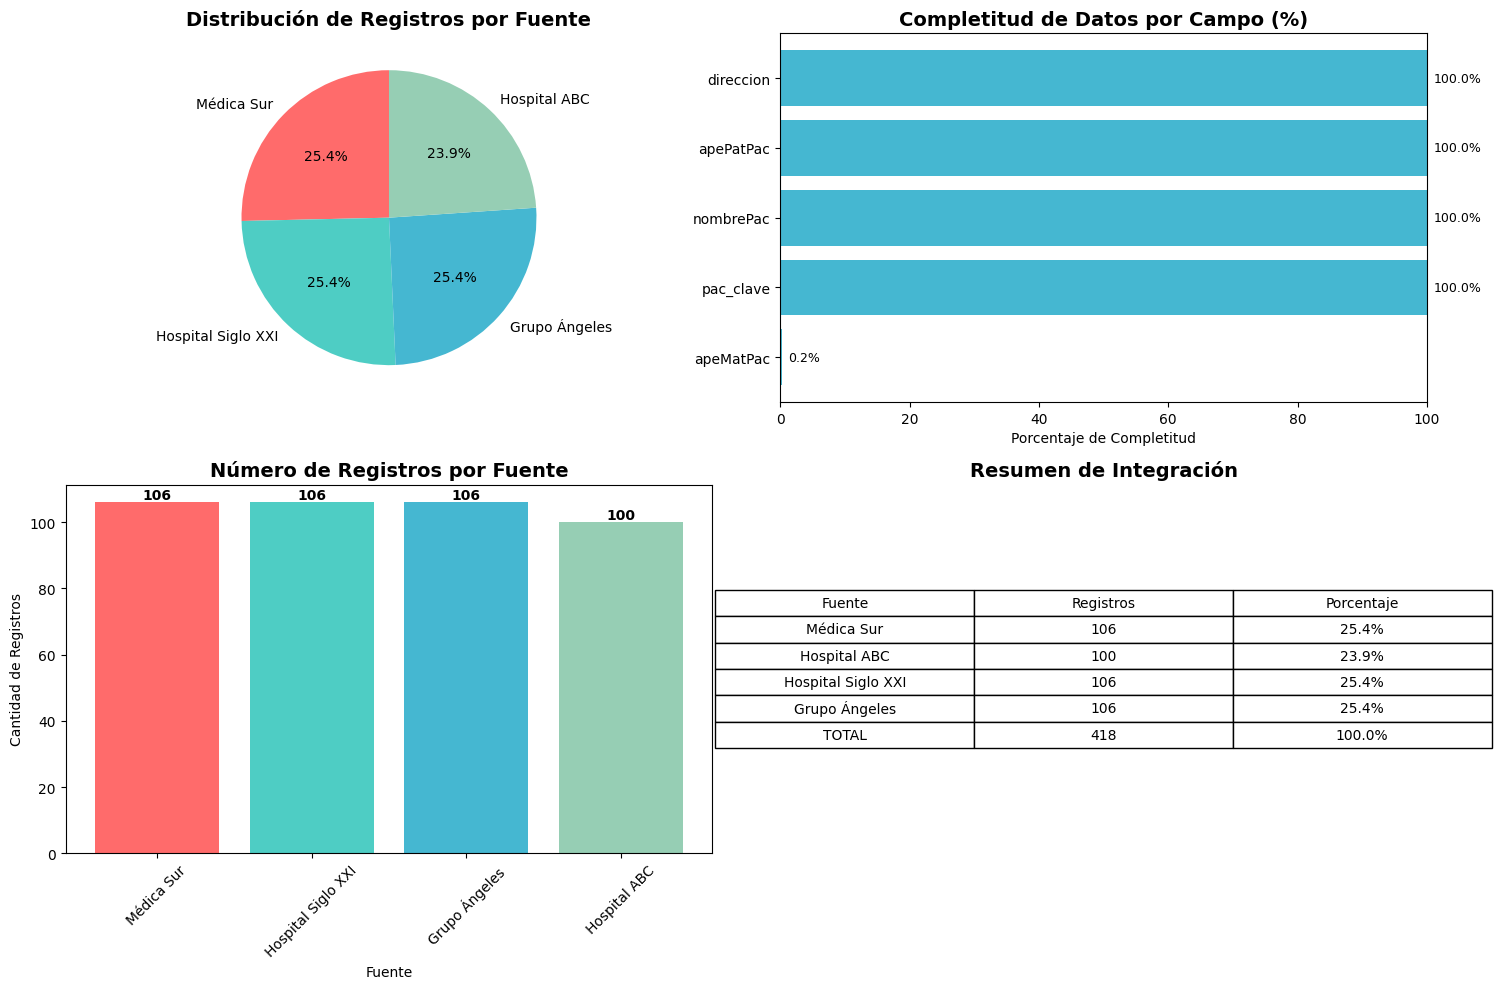


=== DATAFRAME FINAL CONSOLIDADO ===
Total de registros integrados: 418
Total de columnas: 6
Fuentes integradas: 4

=== MUESTRA DEL DATAFRAME FINAL ===
       pac_clave   nombrePac  apePatPac apeMatPac  \
0  16000327 1780      EDUARD    PIZARRO             
1  16010302 5417       EDUAR     ZUNIGA             
2  16020326 9147       JOSUE   SAAVEDRA             
3  16040103 3881      ROXANA  HERNANDEZ             
4  16040309 8312     YORDANO   SANDOVAL             
5  16040827 1112  FRANCHESKA   MARTINEZ             
6  16050310 2196      WILSON  SEPULVEDA             
7  16050310 3191      WILSON  SEPULVEDA             
8  16060630 2586       DUSAN   GONZALEZ             
9  16060728 5434     JHOSTIN    SANCHEZ             

                       direccion  hospOrigen  
0       8369 DIGNISSIM CARRETERA  Médica Sur  
1          933-1665 NON, AVENIDA  Médica Sur  
2       APDO.:384-643 LIBERO AV.  Médica Sur  
3           APDO.:455-7520 ETIAM  Médica Sur  
4             7542 SIT CARRET

In [15]:
# Visualización de resultados
if not df_consolidated.empty:
    print("=== VISUALIZACIÓN DE RESULTADOS ===")

    # Configurar el tamaño de las figuras
    plt.rcParams['figure.figsize'] = (15, 10)

    # Crear subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Distribución por fuente
    source_counts = df_consolidated['hospOrigen'].value_counts()
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
    axes[0,0].pie(source_counts.values, labels=source_counts.index, autopct='%1.1f%%',
                  startangle=90, colors=colors)
    axes[0,0].set_title('Distribución de Registros por Fuente', fontsize=14, fontweight='bold')

    # 2. Completitud de datos
    completeness = {}
    for col in df_consolidated.columns:
        if col != 'hospOrigen':
            non_empty = df_consolidated[col].notna() & (df_consolidated[col] != '')
            completeness[col] = (non_empty.sum() / len(df_consolidated)) * 100

    comp_df = pd.DataFrame(list(completeness.items()), columns=['Campo', 'Completitud'])
    comp_df = comp_df.sort_values('Completitud', ascending=True)

    bars = axes[0,1].barh(comp_df['Campo'], comp_df['Completitud'], color='#45B7D1')
    axes[0,1].set_title('Completitud de Datos por Campo (%)', fontsize=14, fontweight='bold')
    axes[0,1].set_xlabel('Porcentaje de Completitud')
    axes[0,1].set_xlim(0, 100)

    # Añadir valores en las barras
    for i, bar in enumerate(bars):
        width = bar.get_width()
        axes[0,1].text(width + 1, bar.get_y() + bar.get_height()/2,
                      f'{width:.1f}%', ha='left', va='center', fontsize=9)

    # 3. Conteo de registros por fuente (gráfico de barras)
    axes[1,0].bar(source_counts.index, source_counts.values, color=colors)
    axes[1,0].set_title('Número de Registros por Fuente', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel('Fuente')
    axes[1,0].set_ylabel('Cantidad de Registros')
    axes[1,0].tick_params(axis='x', rotation=45)

    # Añadir valores en las barras
    for i, v in enumerate(source_counts.values):
        axes[1,0].text(i, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold')

    # 4. Tabla resumen
    axes[1,1].axis('tight')
    axes[1,1].axis('off')

    # Crear tabla resumen
    summary_data = []
    for fuente in df_consolidated['hospOrigen'].unique():
        count = len(df_consolidated[df_consolidated['hospOrigen'] == fuente])
        pct = (count / len(df_consolidated)) * 100
        summary_data.append([fuente, count, f'{pct:.1f}%'])

    # Agregar total
    summary_data.append(['TOTAL', len(df_consolidated), '100.0%'])

    table = axes[1,1].table(cellText=summary_data,
                           colLabels=['Fuente', 'Registros', 'Porcentaje'],
                           cellLoc='center',
                           loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    axes[1,1].set_title('Resumen de Integración', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Mostrar DataFrame final
    print(f"\n=== DATAFRAME FINAL CONSOLIDADO ===")
    print(f"Total de registros integrados: {len(df_consolidated)}")
    print(f"Total de columnas: {len(df_consolidated.columns)}")
    print(f"Fuentes integradas: {df_consolidated['hospOrigen'].nunique()}")

    print(f"\n=== MUESTRA DEL DATAFRAME FINAL ===")
    print(df_consolidated.head(10))

else:
    print(" No hay datos para visualizar")

## Deduplicación Avanzada con Record Linkage

Implementamos deduplicación inteligente usando la librería **recordlinkage** para:
- Encontrar registros duplicados/similares usando múltiples campos
- Crear registros maestros (Golden Records)
- Generar tabla de metadatos con trazabilidad de registros unificados

In [16]:
# Instalar librerías necesarias para deduplicación
import subprocess
import sys

def install_if_missing(package):
    try:
        __import__(package)
        print(f"✓ {package} ya está instalado")
    except ImportError:
        print(f"Instalando {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✓ {package} instalado exitosamente")

# Instalar librerías de record linkage y análisis
install_if_missing("recordlinkage")
install_if_missing("jellyfish")
install_if_missing("fuzzywuzzy")

print("\nLibrerías de deduplicación verificadas y listas")

Instalando recordlinkage...
✓ recordlinkage instalado exitosamente
✓ jellyfish ya está instalado
Instalando fuzzywuzzy...
✓ fuzzywuzzy instalado exitosamente

Librerías de deduplicación verificadas y listas


In [17]:
# Análisis de duplicados potenciales
if not df_consolidated_copy.empty:
    print("=== ANÁLISIS DE DUPLICADOS POTENCIALES ===")

    # Crear nombre completo para análisis
    df_consolidated_copy['nombre_completo'] = (df_consolidated_copy['nombrePac'] + ' ' +
                                        df_consolidated_copy['apePatPac'] + ' ' +
                                        df_consolidated_copy['apeMatPac']).str.strip()

    # Buscar registros con nombres similares
    print("1. BÚSQUEDA DE NOMBRES SIMILARES:")
    nombre_counts = df_consolidated_copy['nombre_completo'].value_counts()
    duplicados_nombre = nombre_counts[nombre_counts > 1]

    if len(duplicados_nombre) > 0:
        print(f"Encontrados {len(duplicados_nombre)} nombres que aparecen múltiples veces:")
        for nombre, count in duplicados_nombre.head(10).items():
            print(f"  - {nombre}: {count} veces")
            # Mostrar los registros duplicados
            duplicados = df_consolidated_copy[df_consolidated_copy['nombre_completo'] == nombre]
            print(f"    Registros:")
            for idx, row in duplicados.iterrows():
                print(f"      ID: {row['pac_clave']}, Fuente: {row['hospOrigen']}, Dirección: {row['direccion'][:50]}...")
    else:
        print("No se encontraron nombres duplicados exactos")

    print(f"\n2. ANÁLISIS DE IDs DUPLICADOS:")
    id_counts = df_consolidated_copy['pac_clave'].value_counts()
    duplicados_id = id_counts[id_counts > 1]

    if len(duplicados_id) > 0:
        print(f"Encontrados {len(duplicados_id)} IDs que aparecen múltiples veces:")
        for id_val, count in duplicados_id.head(5).items():
            print(f"  - ID {id_val}: {count} veces")
    else:
        print("No se encontraron IDs duplicados")

    print(f"\n3. ESTADÍSTICAS GENERALES:")
    print(f"Total de registros: {len(df_consolidated_copy)}")
    print(f"Nombres únicos: {df_consolidated_copy['nombre_completo'].nunique()}")
    print(f"IDs únicos: {df_consolidated_copy['pac_clave'].nunique()}")

else:
    print("No hay datos para analizar duplicados")

=== ANÁLISIS DE DUPLICADOS POTENCIALES ===
1. BÚSQUEDA DE NOMBRES SIMILARES:
Encontrados 47 nombres que aparecen múltiples veces:
  - BRENNA FITZGERALD: 2 veces
    Registros:
      ID: 16905738, Fuente: Grupo Ángeles, Dirección: 413-227 MALESUADA CTRA....
      ID: 16905736, Fuente: Grupo Ángeles, Dirección: 413-227 MALESUADA CTRA....
  - "GABRIEL" "JIMENEZ": 2 veces
    Registros:
      ID: "95998168299", Fuente: Hospital Siglo XXI, Dirección: "6842 VITAE C."...
      ID: "95998168299", Fuente: Hospital Siglo XXI, Dirección: "6842 VITAE C."...
  - "THOMAS" "LOPEZ": 2 veces
    Registros:
      ID: "19878800599", Fuente: Hospital Siglo XXI, Dirección: "APARTADO NUM.: 167...
      ID: "19740800599", Fuente: Hospital Siglo XXI, Dirección: "APARTADO NUM.: 167...
  - "GISELA" "GODOY": 2 veces
    Registros:
      ID: "376255099", Fuente: Hospital Siglo XXI, Dirección: "519-2193 QUISQUE CALLE"...
      ID: "37692255099", Fuente: Hospital Siglo XXI, Dirección: "519-2193 QUISQUE CALLE"...
  

In [18]:
# Deduplicación inteligente usando múltiples criterios
if not df_consolidated_copy.empty:
    print("=== DEDUPLICACIÓN INTELIGENTE ===")

    # Crear una función para detectar duplicados basándose en múltiples criterios
    def detect_duplicates(df):
        """Detecta duplicados usando múltiples criterios de similitud"""

        # Criterio 1: Mismo ID de paciente
        id_duplicates = df[df.duplicated(subset=['pac_clave'], keep=False)]

        # Criterio 2: Mismo nombre completo y dirección similar
        name_duplicates = df[df.duplicated(subset=['nombre_completo'], keep=False)]

        # Criterio 3: Combinación de nombre + apellido paterno + dirección
        combo_duplicates = df[df.duplicated(subset=['nombrePac', 'apePatPac', 'direccion'], keep=False)]

        return {
            'id_duplicates': id_duplicates,
            'name_duplicates': name_duplicates,
            'combo_duplicates': combo_duplicates
        }

    # Detectar duplicados
    duplicates = detect_duplicates(df_consolidated_copy)

    print("1. DUPLICADOS POR ID:")
    if not duplicates['id_duplicates'].empty:
        print(f"Encontrados {len(duplicates['id_duplicates'])} registros con IDs duplicados")
        print(duplicates['id_duplicates'][['pac_clave', 'nombre_completo', 'hospOrigen']].head())
    else:
        print("No se encontraron duplicados por ID")

    print(f"\n2. DUPLICADOS POR NOMBRE COMPLETO:")
    if not duplicates['name_duplicates'].empty:
        print(f"Encontrados {len(duplicates['name_duplicates'])} registros con nombres duplicados")
        print(duplicates['name_duplicates'][['pac_clave', 'nombre_completo', 'hospOrigen']].head())
    else:
        print("No se encontraron duplicados por nombre completo")

    print(f"\n3. DUPLICADOS POR COMBINACIÓN NOMBRE+APELLIDO+DIRECCIÓN:")
    if not duplicates['combo_duplicates'].empty:
        print(f"Encontrados {len(duplicates['combo_duplicates'])} registros con combinación duplicada")
        print(duplicates['combo_duplicates'][['pac_clave', 'nombrePac', 'apePatPac', 'hospOrigen']].head())
    else:
        print("No se encontraron duplicados por combinación")

    # Aplicar deduplicación
    print(f"\n4. APLICANDO DEDUPLICACIÓN:")
    initial_count = len(df_consolidated_copy)

    # Eliminar duplicados basándose en ID (mantener el primero)
    df_deduplicated = df_consolidated_copy.drop_duplicates(subset=['pac_clave'], keep='first')

    # Para duplicados por nombre, mantener el de la fuente con más registros
    source_priority = df_deduplicated['hospOrigen'].value_counts().index.tolist()

    def keep_best_duplicate(group):
        if len(group) == 1:
            return group
        # Ordenar por prioridad de fuente
        group['priority'] = group['hospOrigen'].map({source: i for i, source in enumerate(source_priority)})
        return group.sort_values('priority').head(1)

    # Aplicar deduplicación por nombre completo
    df_final = df_deduplicated.groupby('nombre_completo').apply(keep_best_duplicate).reset_index(drop=True)
    df_final = df_final.drop('priority', axis=1, errors='ignore')

    final_count = len(df_final)
    duplicates_removed = initial_count - final_count

    print(f"Registros originales: {initial_count}")
    print(f"Registros después de deduplicación: {final_count}")
    print(f"Duplicados eliminados: {duplicates_removed}")

    # Mostrar resumen final
    print(f"\n5. RESUMEN FINAL:")
    print(f"Fuentes en datos finales: {df_final['hospOrigen'].value_counts().to_dict()}")

    # Guardar el DataFrame final
    df_consolidated_final = df_final.copy()

else:
    print("No hay datos para deduplicar")
    df_consolidated_final = df_consolidated.copy()

=== DEDUPLICACIÓN INTELIGENTE ===
1. DUPLICADOS POR ID:
Encontrados 58 registros con IDs duplicados
        pac_clave  nombre_completo  hospOrigen
62  16620320 7953     GREGORY RUIZ  Médica Sur
63  16620320 7953     GREGORY RUIZ  Médica Sur
67  16670724 7463  SCARLET ARAVENA  Médica Sur
68  16670724 7463  SCARLET ARAVENA  Médica Sur
70  16681105 3377  VALENTIN TORRES  Médica Sur

2. DUPLICADOS POR NOMBRE COMPLETO:
Encontrados 94 registros con nombres duplicados
        pac_clave   nombre_completo  hospOrigen
6   16050310 2196  WILSON SEPULVEDA  Médica Sur
7   16050310 3191  WILSON SEPULVEDA  Médica Sur
12  16100207 0470      ROLANDO VEGA  Médica Sur
13  16100207 5479      ROLANDO VEGA  Médica Sur
15  16140925 0362       MATIAS DIAZ  Médica Sur

3. DUPLICADOS POR COMBINACIÓN NOMBRE+APELLIDO+DIRECCIÓN:
Encontrados 94 registros con combinación duplicada
        pac_clave nombrePac  apePatPac  hospOrigen
6   16050310 2196    WILSON  SEPULVEDA  Médica Sur
7   16050310 3191    WILSON  SEPULV

In [19]:
# Análisis final de calidad de datos
if not df_consolidated_final.empty:
    print("=== ANÁLISIS FINAL DE CALIDAD DE DATOS ===")

    # Estadísticas generales
    print(f"1. ESTADÍSTICAS GENERALES:")
    print(f"Total de registros finales: {len(df_consolidated_final)}")
    print(f"Total de columnas: {len(df_consolidated_final.columns)}")
    print(f"Fuentes únicas: {df_consolidated_final['hospOrigen'].nunique()}")

    # Distribución por fuente
    print(f"\n2. DISTRIBUCIÓN POR FUENTE:")
    source_dist = df_consolidated_final['hospOrigen'].value_counts()
    for fuente, count in source_dist.items():
        percentage = (count / len(df_consolidated_final)) * 100
        print(f"  {fuente}: {count} registros ({percentage:.1f}%)")

    # Completitud de campos críticos
    print(f"\n3. COMPLETITUD DE CAMPOS CRÍTICOS:")
    critical_fields = ['nombrePac', 'apePatPac', 'direccion', 'hospOrigen']
    for field in critical_fields:
        non_empty = df_consolidated_final[field].notna() & (df_consolidated_final[field] != '')
        completeness = (non_empty.sum() / len(df_consolidated_final)) * 100
        print(f"  {field}: {completeness:.1f}% completo")

    # Análisis de apellidos maternos (que sabemos que están mayormente vacíos)
    ape_mat_completeness = (df_consolidated_final['apeMatPac'].notna() &
                           (df_consolidated_final['apeMatPac'] != '')).sum()
    ape_mat_pct = (ape_mat_completeness / len(df_consolidated_final)) * 100
    print(f"  apeMatPac: {ape_mat_pct:.1f}% completo")

    # Valores únicos
    print(f"\n4. DIVERSIDAD DE DATOS:")
    print(f"  Nombres únicos: {df_consolidated_final['nombrePac'].nunique()}")
    print(f"  Apellidos paternos únicos: {df_consolidated_final['apePatPac'].nunique()}")
    print(f"  Direcciones únicas: {df_consolidated_final['direccion'].nunique()}")

    # Muestra de datos finales
    print(f"\n5. MUESTRA DE DATOS FINALES:")
    print(df_consolidated_final[['pac_clave', 'nombrePac', 'apePatPac', 'hospOrigen']].head(10))

else:
    print("No hay datos finales para analizar")

=== ANÁLISIS FINAL DE CALIDAD DE DATOS ===
1. ESTADÍSTICAS GENERALES:
Total de registros finales: 400
Total de columnas: 7
Fuentes únicas: 4

2. DISTRIBUCIÓN POR FUENTE:
  Hospital Siglo XXI: 100 registros (25.0%)
  Hospital ABC: 100 registros (25.0%)
  Médica Sur: 100 registros (25.0%)
  Grupo Ángeles: 100 registros (25.0%)

3. COMPLETITUD DE CAMPOS CRÍTICOS:
  nombrePac: 100.0% completo
  apePatPac: 100.0% completo
  direccion: 100.0% completo
  hospOrigen: 100.0% completo
  apeMatPac: 0.2% completo

4. DIVERSIDAD DE DATOS:
  Nombres únicos: 378
  Apellidos paternos únicos: 246
  Direcciones únicas: 400

5. MUESTRA DE DATOS FINALES:
       pac_clave    nombrePac   apePatPac          hospOrigen
0  "42976852699"    "ABIGAIL"    "VARGAS"  Hospital Siglo XXI
1  "91432878699"      "ABNER"  "SANDOVAL"  Hospital Siglo XXI
2  "04779643499"       "ADAM"   "VERGARA"  Hospital Siglo XXI
3  "61441450199"    "AGUSTIN"     "ARAYA"  Hospital Siglo XXI
4  "25496940399"     "ALEXIS"      "SOTO"  Hosp